## 『本次練習內容』
#### 學習如何搭建 Residual Block
####  學習如何搭建Inception-ResNet中的 Inception Block

## 『本次練習目的』
  #### 了解 Residual Block原理
  #### 了解如何結合Inception 與 Residual概念

---

## Part1

In [62]:
import numpy as np
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras import backend as K
from keras import layers
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Lambda

![Incpeiton](ResNet_Structure.png)

## ResNetV1

In [63]:
def Residual_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=3, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=3, name=bn_name_base + '2b')(x)
   

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

## 參考ResNetV1 搭建 ResNetV2版本的Residual Block

In [64]:
def Residual_block_v2(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = BatchNormalization(axis=3, name=bn_name_base + '2a')(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(x)
    
    
    x = BatchNormalization(axis=3, name=bn_name_base + '2b')(x)   
    x = Activation('relu')(x)
    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)

    x = layers.add([x, input_tensor])
    
    return x

## 試試看自己設計一個先壓縮再回放的V2 Block

In [65]:
def Residual_block_v2(input_tensor, kernel_size, stage, block,reduce=96,ouput_size=128):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    x = Conv2D(reduce, (1, 1), name=conv_name_base + '2a')(x)
    x = BatchNormalization(axis=3, name=bn_name_base + '2a')(input_tensor)
    x = Activation('relu')(x)
    
    x = Conv2D(ouput_size, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=3, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(ouput_size, (1, 1), name=conv_name_base + '2c')(x)
    
    x = layers.add([x, input_tensor])
    return x


---

## Part2

## Incpetion Block-A

![Incpeiton](Inception-ResNet-A.png)

## Incpetion Block-B

![Incpeiton](Inception-ResNet-B.png)

## Incpetion Block-C

![Incpeiton](Inception-ResNet-C.png)

In [66]:
def Conv2d_bn(x,filters,kernel_size,padding='same',strides=(1, 1),normalizer=True,activation='relu',name=None):
    if name is not None:
        conv_name = name + '_conv'
        bn_name = name + '_bn'
        act_name = name + '_act'
    else:
        conv_name = None
        bn_name = None
        act_name = None
    if K.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    x = Conv2D(filters, kernel_size,
               strides=strides, padding=padding,
               use_bias=False, name=conv_name)(x)
    if normalizer:
        x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    if activation:
        x = Activation(activation, name=act_name)(x)
    return x

In [67]:
def Residual_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=3, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=3, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=3, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

## 參考上方Residual_block搭建 Inception-ResNet中的Inception Block

In [68]:
def inception_resnet_block(x, scale, block_type, activation='relu'):
    '''scale: scaling factor to scale the residuals (i.e., the output of
            passing `x` through an inception module) before adding them
            to the shortcut branch. Let `r` be the output from the residual branch,
            the output of this block will be `x + scale * r`.(簡單來說就是控制Residual branch的比例)'''
    if block_type == 'Incpetion_Block-A':
        branch_0 = Conv2d_bn(x,32,(1,1),name=block_type+'b0')
        branch_1 = Conv2d_bn(x,32,(1,1),name=block_type+'b1_1')
        branch_1 = Conv2d_bn(branch_1,32,(3,3),name=block_type+'b1_2')
        branch_2 = Conv2d_bn(x,32,(1,1),name=block_type+'b2_1')
        branch_2 = Conv2d_bn(branch_2,48,(3,3),name=block_type+'b2_2')
        branch_2 = Conv2d_bn(branch_2,64,(3,1),name=block_type+'b2_3')
        branches = [branch_0, branch_1, branch_2]
    elif block_type == 'Incpetion_Block-B':
        branch_0 = Conv2d_bn(x,192,(1,1),name=block_type+'b0')
        branch_1 = Conv2d_bn(x,128,(1,1),name=block_type+'b1_1')
        branch_1 = Conv2d_bn(branch_1,160,(1,7),name=block_type+'b1_2')
        branch_1 = Conv2d_bn(branch_1,192,(7,1),name=block_type+'b1_3')
        branches = [branch_0, branch_1]
    elif block_type == 'Incpetion_Block-C':
        branch_0 = Conv2d_bn(x,192,(1,1),name=block_type+'b0')
        branch_1 = Conv2d_bn(x,192,(1,1),name=block_type+'b1_1')
        branch_1 = Conv2d_bn(branch_1,224,(1,3),name=block_type+'b1_2')
        branch_1 = Conv2d_bn(branch_1,256,(3,1),name=block_type+'b1_3')
        branches = [branch_0, branch_1]
    else:
        raise ValueError('Unknown Inception-ResNet block type. '
                         'Expects "block35", "block17" or "block8", '
                         'but got: ' + str(block_type))
    mixed = Concatenate(axis=3)(branches)
    
    '''確保輸入跟輸出深度相同'''
    up = Conv2d_bn(mixed,K.int_shape(x)[3],1,activation=None)
    
    '''導入殘差結構，並給予權重'''
    
    x = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale, ##提示inputs[0]、inputs[1]
               output_shape=K.int_shape(x)[1:],
               arguments={'scale': scale},)([x,up])

    if activation is not None:
        x = Activation(activation)(x)
    return x

In [69]:
img_input = Input(shape=(224,224,32))
x=inception_resnet_block(img_input, 0.1, 'Incpetion_Block-A', activation='relu')
print(x)

Tensor("activation_27/Relu:0", shape=(None, 224, 224, 32), dtype=float32)


## 測試

In [70]:
img_input = Input(shape=(224,224,32))
x=inception_resnet_block(img_input, 0.1, 'Incpetion_Block-A', activation='relu')
print(x)

Tensor("activation_28/Relu:0", shape=(None, 224, 224, 32), dtype=float32)


In [71]:
img_input = Input(shape=(224,224,32))
x=inception_resnet_block(img_input, 0.1, 'Incpetion_Block-B', activation='relu')
print(x)

Tensor("activation_29/Relu:0", shape=(None, 224, 224, 32), dtype=float32)


In [72]:
img_input = Input(shape=(224,224,32))
x=inception_resnet_block(img_input, 0.1, 'Incpetion_Block-C', activation='relu')
print(x)

Tensor("activation_30/Relu:0", shape=(None, 224, 224, 32), dtype=float32)


## 嘗試導入Inception Block到 Vgg_Inception中

In [73]:
def VGG16_ResNet_Inception(include_top=True,input_tensor=None, input_shape=(224,224,1),
          pooling='max',classes=1000):
 
    img_input = Input(shape=input_shape)
    
    x = Conv2d_bn(img_input,64, (3, 3), activation='relu', padding='same', name='block1_conv1')
    x = Conv2d_bn(x,64, (3, 3), activation='relu', padding='same', name='block1_conv2')
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2d_bn(x,128, (3, 3), activation='relu', padding='same', name='block2_conv1')
    x = Conv2d_bn(x,128, (3, 3), activation='relu', padding='same', name='block2_conv2')
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = InceptionV1_block(x, ((64,), (96,128), (16,32), (32,)), 3, 'Block_1')
    x = InceptionV1_block(x, ((64,), (96,128), (16,32), (32,)), 3, 'Block_2')
    x = InceptionV1_block(x, ((64,), (96,128), (16,32), (32,)), 3, 'Block_3')
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = inception_resnet_block(x, 0.1, 'Incpetion_Block-A', activation='relu')
    x = inception_resnet_block(x, 0.1, 'Incpetion_Block-B', activation='relu')
    x = inception_resnet_block(x, 0.1, 'Incpetion_Block-C', activation='relu')
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5 
    #為什麼要加InceptionV3_block 原因?
    x =InceptionV3_block(x, ((128,), (192,256), (32,64), (64,)), 3, 'Block_5-1')
    x =InceptionV3_block(x, ((128,), (192,256), (32,64), (64,)), 3, 'Block_5-2')
    x =InceptionV3_block(x, ((128,), (192,256), (32,64), (64,)), 3, 'Block_5-3')
    x =MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
       #可以提醒學員為什麼要加avg或是max
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16')

   
    return model



In [74]:
def InceptionV1_block(x, specs,channel_axis, name):
    (br0, br1, br2, br3) = specs   # ((64,), (96,128), (16,32), (32,))
    branch_0 = Conv2d_bn(x, br0[0], (1, 1), name=name+"_Branch_0")

    branch_1 = Conv2d_bn(x, br1[0], (1, 1), name=name+"_Branch_1")
    branch_1 = Conv2d_bn(branch_1, br1[1], (3, 3), name=name+"_Branch_1_1")

    '''Branch_2'''
    branch_2 = Conv2d_bn(x, br2[0], (1, 1), name=name+"_Branch_2")
    branch_2 = Conv2d_bn(branch_2, br2[1], (5, 5), name=name+"_Branch_2_1")

    '''Branch_3'''
    branch_3 = MaxPooling2D(pool_size=3, strides=1, padding='same')(x)
    branch_3 = Conv2d_bn(branch_3, br3[0], (1, 1), name=name+"_Branch_3")
    

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name=name+"_Concatenated")
    return x

In [75]:
def InceptionV3_block(x, specs,channel_axis, name):
    (br0, br1, br2, br3) = specs   # ((64,), (96,128), (16,32), (32,))
    branch_0 = Conv2d_bn(x, br0[0], (1, 1), name=name+"_Branch_0")

    branch_1 = Conv2d_bn(x, br1[0], (1, 1), name=name+"_Branch_1")
    branch_1 = Conv2d_bn(branch_1, br1[1], (1, 3), name=name+"_Branch_1_1")
    branch_1 = Conv2d_bn(branch_1, br1[1], (3, 1), name=name+"_Branch_1_2")

    '''Branch_2'''
    branch_2 = Conv2d_bn(x, br2[0], (1, 1), name=name+"_Branch_2")
    branch_2 = Conv2d_bn(branch_2, br2[1], (1, 5), name=name+"_Branch_2_1")
    branch_2 = Conv2d_bn(branch_2, br2[1], (5, 1), name=name+"_Branch_2_2")

    '''Branch_3'''
    branch_3 = MaxPooling2D(pool_size=3, strides=1, padding='same')(x)
    branch_3 = Conv2d_bn(branch_3, br3[0], (1, 1), name=name+"_Branch_3")

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name=name+"_Concatenated")
    return x

In [76]:
model = VGG16_ResNet_Inception(include_top=False)

In [77]:
model.summary()

Model: "vgg16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
block1_conv1_conv (Conv2D)      (None, 224, 224, 64) 576         input_23[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 224, 224, 64) 192         block1_conv1_conv[0][0]          
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 224, 224, 64) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

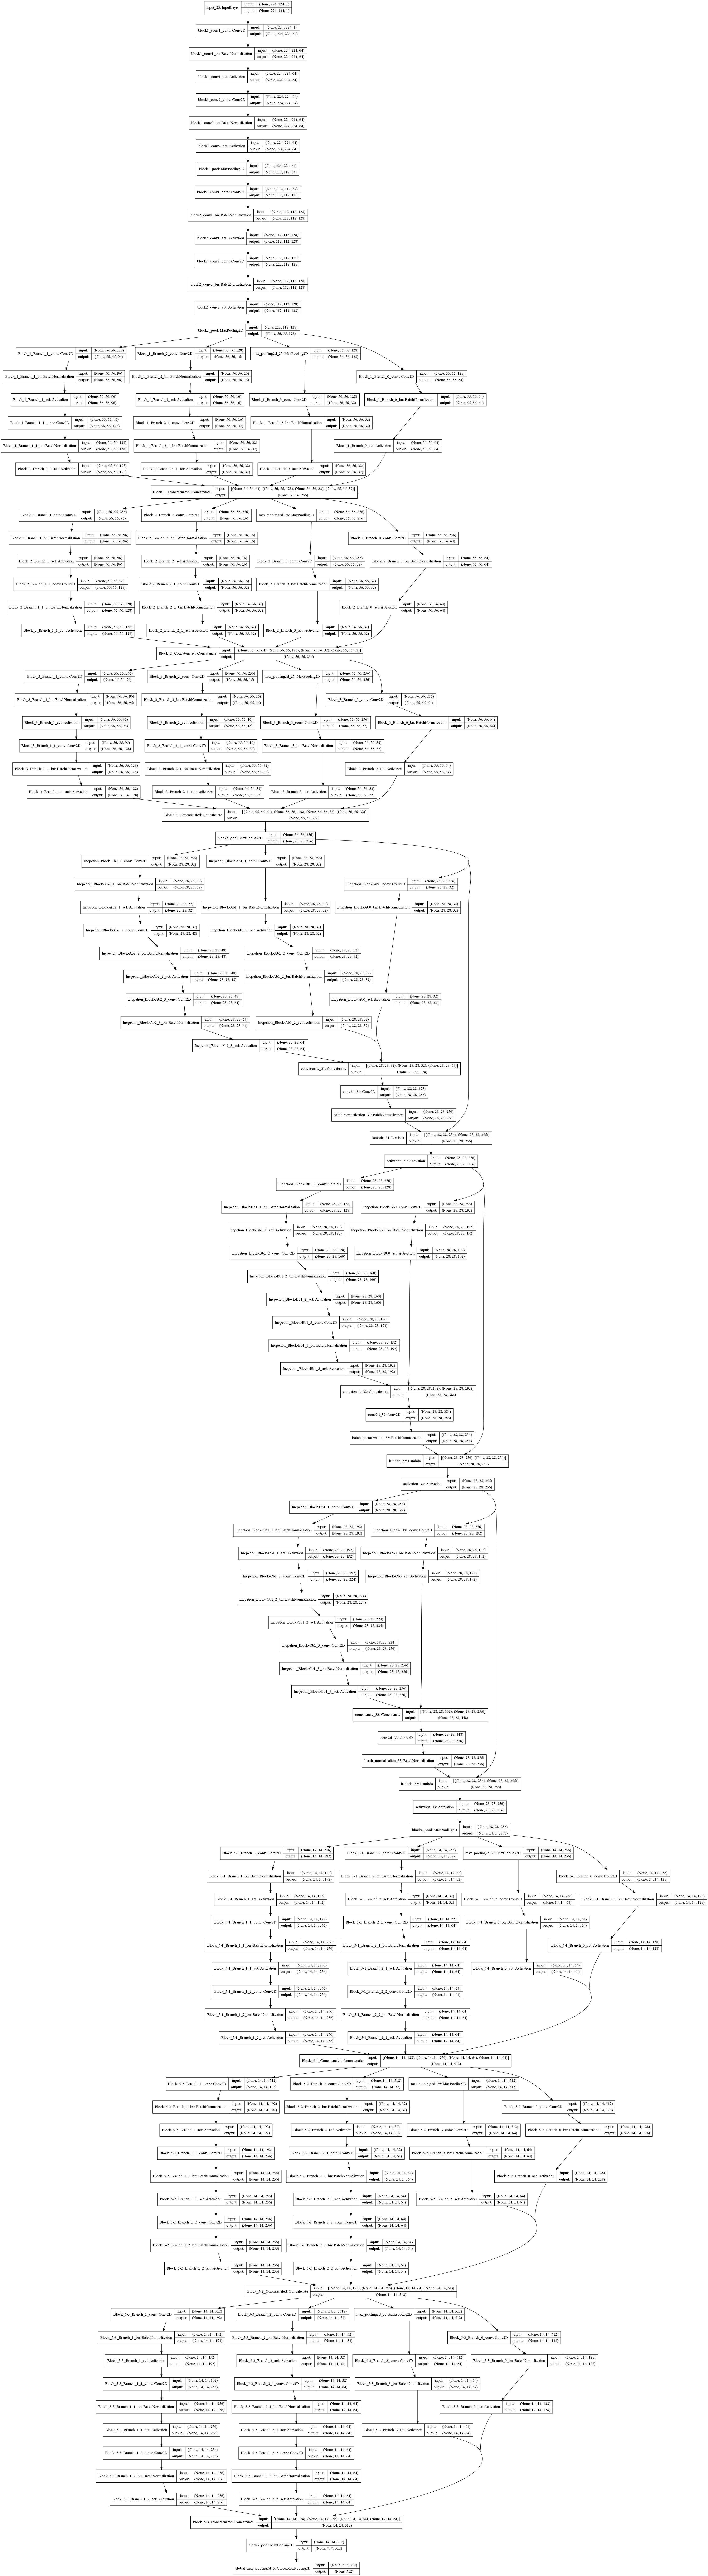

In [78]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='VGG16_ResNet_Inception.png', show_shapes=True, show_layer_names=True)